<a href="https://colab.research.google.com/github/pranay8297/fastaip2/blob/main/hooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==2.1.0
!pip install datasets
!pip install torchaudio=0.3.0
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [3]:
import torch
import torch.functional as F
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
from functools import partial
from collections.abc import Mapping
from operator import methodcaller, attrgetter, itemgetter

from miniai.datasets import *
from miniai.learner import *

In [4]:
import fastcore.all as fc

In [10]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_tensor

In [20]:
import random
import numpy as np
from torcheval.metrics import MulticlassAccuracy

In [6]:
dsd = load_dataset('fashion_mnist')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [47]:
def new(some_data):
  def transform(some_data):
    some_data['image'] = [to_tensor(i) for i in some_data['image']]
  transform(some_data)

  return some_data

def collate_fn(some_data):
  sd = (i.values() for i in some_data)
  xs, ys = zip(*sd)
  return torch.stack(xs), torch.tensor(ys)

tds = dsd.with_transform(new)
dls = DataLoaders.from_dd(tds, 512, num_workers=2)
# train_dl, valid_dl = f(tds['train'], shuffle = True), f(tds['test'])

In [48]:
dt = dls.train

In [16]:
def set_seed(seed, deterministic = False):
  torch.use_deterministic_algorithms(deterministic)
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)

In [17]:
set_seed(1)

In [51]:
def conv(nin, nout, stride = 2, ks = 3, relu = True):
  layers = [nn.Conv2d(nin, nout, stride = stride, kernel_size = ks, padding = ks//2)]
  if relu: layers.append(nn.ReLU())
  return nn.Sequential(*layers)

def gl():
  return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, relu=False),  #1x1
        nn.Flatten()]

def gm(layers = None):
  if not layers: layers = gl()
  return nn.Sequential(*layers)

In [52]:
metrics = MetricsCB(accuracy = MulticlassAccuracy())
learner = Learner(gm(), dls = dls, loss_func = nn.CrossEntropyLoss(), lr = 0.6, cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)])

accuracy,loss,epoch,train
0.262,2.026,0,train
0.100,2.311,0,eval


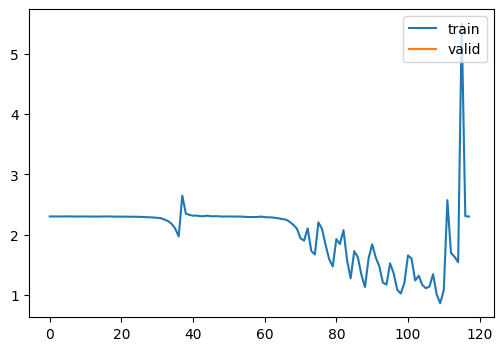

In [53]:
learner.fit(1)

In [62]:
class ActModel(nn.Module):
  def __init__(self, layers = None):
    super().__init__()
    self.layers = nn.ModuleList(layers if layers else gl())
    self.acts_mean = [[] for i in self.layers]
    self.acts_std = [[] for i in self.layers]

  def forward(self, x):
    for i, l in enumerate(self.layers):
      acts = l(x)
      self.acts_mean[i].append(to_cpu(acts).mean())
      self.acts_std[i].append(to_cpu(acts).std())
      x = acts
    return acts

  def __iter__(self): return iter(self.layers)

In [63]:
metrics = MetricsCB(accuracy = MulticlassAccuracy())
learner = Learner(ActModel(), dls = dls, loss_func = nn.CrossEntropyLoss(), lr = 0.6, cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)])

accuracy,loss,epoch,train
0.169,2.256,0,train
0.100,2.303,0,eval


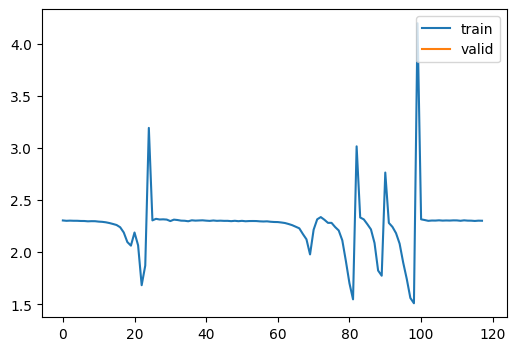

In [64]:
learner.fit(1)

In [66]:
model = learner.model

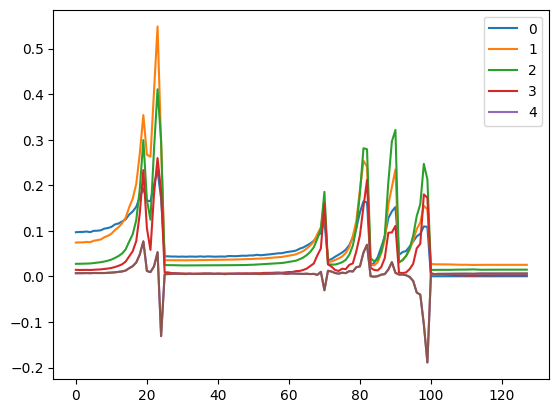

In [67]:
for i in model.acts_mean:
  plt.plot(i)
plt.legend(range(5));

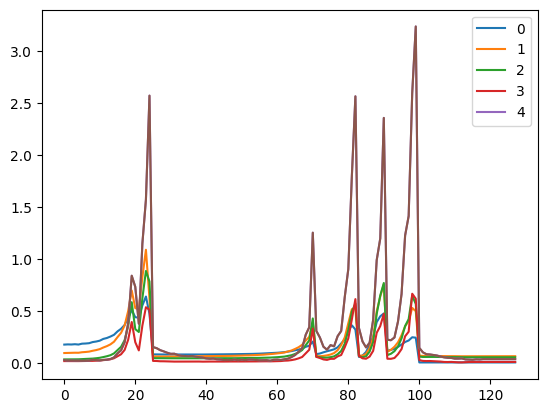

In [68]:
for i in model.acts_std:
  plt.plot(i)
plt.legend(range(5));

In [81]:
# Lets do it hooks now

layers = gl()
model = nn.Sequential(*layers)

act_means = [[] for i in layers]
act_std = [[] for i in layers]

def hook_ops(i, model, inp, out):
  act_means[i].append(to_cpu(out).mean())
  act_std[i].append(to_cpu(out).std())

for i, l in enumerate(layers):
  l.register_forward_hook(partial(hook_ops, i))

In [82]:
learner = Learner(model,
                  dls = dls,
                  loss_func = nn.CrossEntropyLoss(),
                  lr = 0.6,
                  cbs = [TrainCB(), DeviceCB(), MetricsCB(accuracy = MulticlassAccuracy()), ProgressCB(plot=True)]
                )

accuracy,loss,epoch,train
0.269,1.993,0,train
0.494,1.146,0,eval


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a6f9c959f30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a6f9c959f30>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    self._shutdown_workers()AssertionError
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    : can only test a child processif w.is_alive():

  File "/usr/lib/

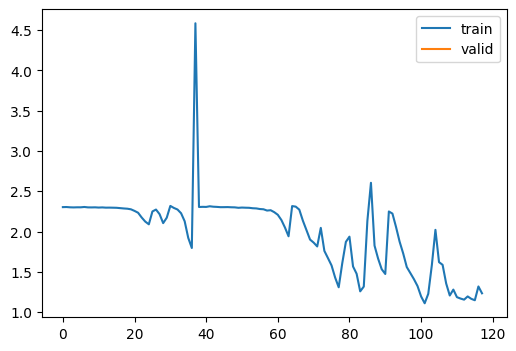

In [83]:
learner.fit(1)

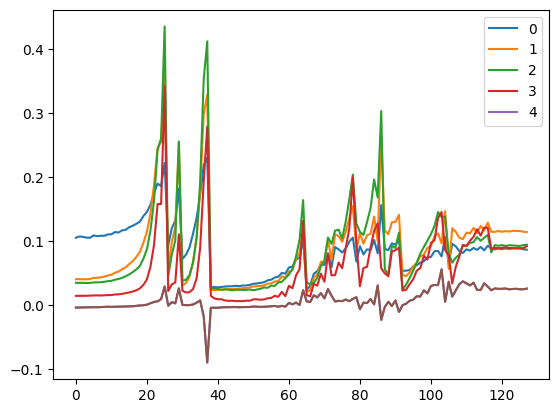

In [84]:
for i in act_means: plt.plot(i)
plt.legend(range(5))

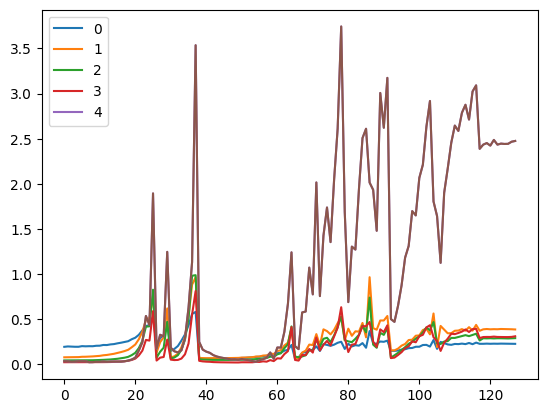

In [85]:
for i in act_std: plt.plot(i)
plt.legend(range(5))

In [99]:
class Hook():
  def __init__(self, module):
    self.module = module
    self.means = []
    self.std = []
    self.hook = self.module.register_forward_hook(partial(store_stats, self))

  def __del__(self):
    self.hook.remove()

  def remove(self):
    self.hook.remove()

def store_stats(hook, model, inp, out):
  hook.means.append(to_cpu(out).mean())
  hook.std.append(to_cpu(out).std())

In [100]:
layers = gl()
model = nn.Sequential(*layers)
hooks = [Hook(l) for l in layers]
learner = Learner(model,
                  dls = dls,
                  loss_func = nn.CrossEntropyLoss(),
                  lr = 0.6,
                  cbs = [TrainCB(), DeviceCB(), MetricsCB(accuracy = MulticlassAccuracy()), ProgressCB(plot=True)]
                )

accuracy,loss,epoch,train
0.129,2.409,0,train
0.100,2.304,0,eval


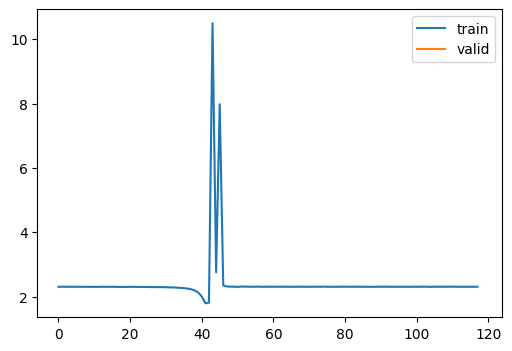

In [96]:
learner.fit(1)

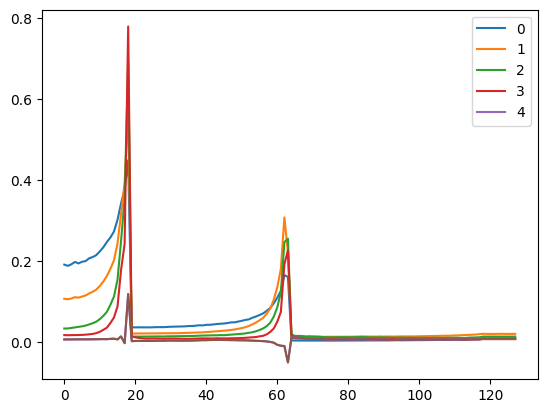

In [91]:
for i in hooks: plt.plot(i.means)
plt.legend(range(5))

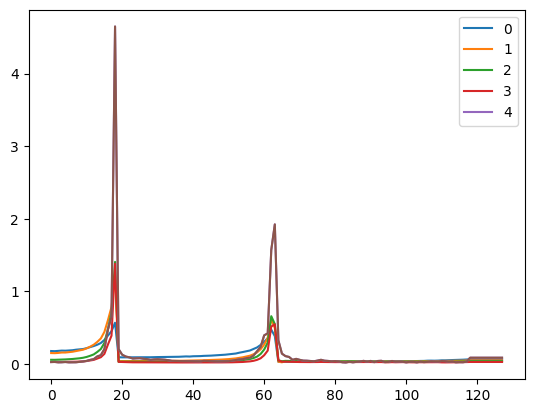

In [92]:
for i in hooks: plt.plot(i.std)
plt.legend(range(5))

In [101]:
# Context manager class:
class Hooks():
  def __init__(self, layers):
    self.hooks = [Hook(layer) for layer in layers]
    self.layers = layers

  def __enter__(self, *args): return self
  def __exit__(self, *args): self.remove()
  def remove(self): [hook.remove() for hook in self.hooks]
  def __iter__(self, *args): return iter(self.hooks)
  def __del__(self, *args): self.remove()

accuracy,loss,epoch,train
0.370,1.748,0,train
0.707,0.789,0,eval
0.745,0.685,1,train
0.779,0.629,1,eval


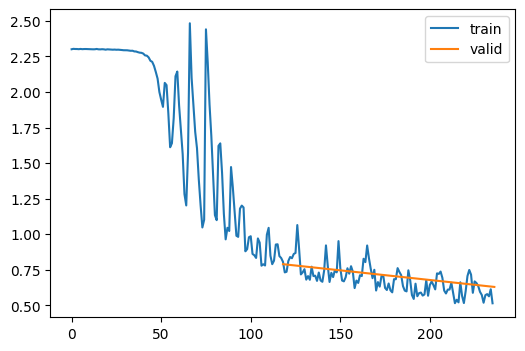

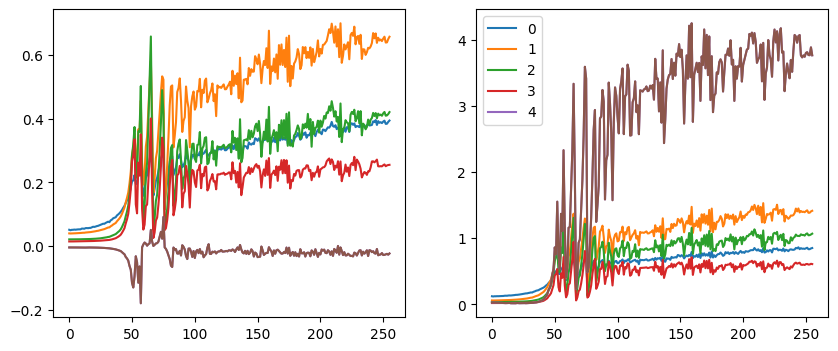

In [105]:
layers = gl()
model = nn.Sequential(*layers)
learner = Learner(model,
                  dls = dls,
                  loss_func = nn.CrossEntropyLoss(),
                  lr = 0.3,
                  cbs = [TrainCB(), DeviceCB(), MetricsCB(accuracy = MulticlassAccuracy()), ProgressCB(plot=True)]
                )
with Hooks(layers) as hooks:
  learner.fit(2)
  fit, axis = plt.subplots(1, 2, figsize = (10, 4))
  for h in hooks:
    for i in (0, 1): axis[i].plot(h.means if i == 0 else h.std)
  plt.legend(range(5))

In [107]:
from ipdb import set_trace as st

In [112]:
class Hook():
  def __init__(self, module):
    self.module = module
    self.stats = [[],[],[]]
    self.hook = self.module.register_forward_hook(partial(append_stats, self))

  def __del__(self):
    self.hook.remove()

  def remove(self):
    self.hook.remove()

def append_stats(hook, model, inp, out):
  acts = to_cpu(out)
  # st()
  hook.stats[0].append(acts.mean())
  hook.stats[1].append(acts.std())
  hook.stats[2].append(acts.abs().histc(40,0,10))

In [113]:
# Context manager class:
class Hooks():
  def __init__(self, layers):
    self.hooks = [Hook(layer) for layer in layers]
    self.layers = layers

  def __enter__(self, *args): return self
  def __exit__(self, *args): self.remove()
  def remove(self): [hook.remove() for hook in self.hooks]
  def __iter__(self, *args): return iter(self.hooks)
  def __del__(self, *args): self.remove()

accuracy,loss,epoch,train
0.247,2.137,0,train
0.586,1.110,0,eval


Exception ignored in: <function Hooks.__del__ at 0x7a6f6962ce50>
Traceback (most recent call last):
  File "<ipython-input-97-9c2288247fa7>", line 11, in __del__
  File "<ipython-input-97-9c2288247fa7>", line 9, in remove
  File "<ipython-input-97-9c2288247fa7>", line 9, in <listcomp>
AttributeErrorException ignored in: : <function Hooks.__del__ at 0x7a6f6962ce50>'Hook' object has no attribute 'remove'

Traceback (most recent call last):
  File "<ipython-input-97-9c2288247fa7>", line 11, in __del__
  File "<ipython-input-97-9c2288247fa7>", line 9, in remove
  File "<ipython-input-97-9c2288247fa7>", line 9, in <listcomp>
AttributeError: 'Hook' object has no attribute 'remove'


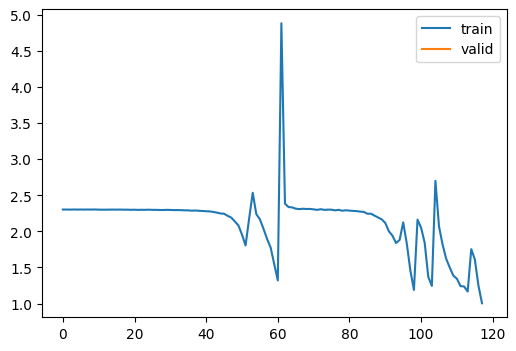

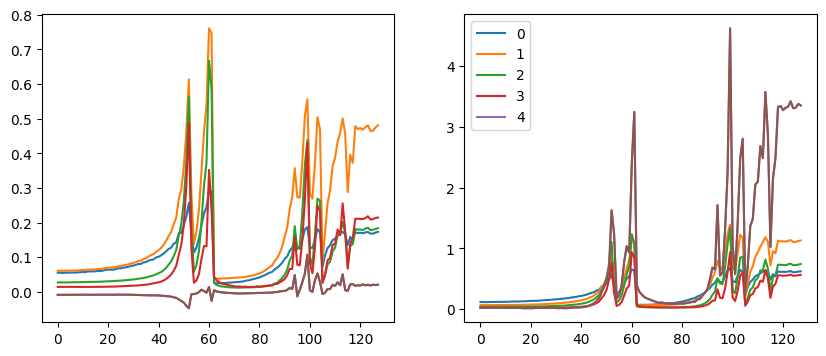

In [116]:
  layers = gl()
model = nn.Sequential(*layers)
learner = Learner(model,
                  dls = dls,
                  loss_func = nn.CrossEntropyLoss(),
                  lr = 0.3,
                  cbs = [TrainCB(), DeviceCB(), MetricsCB(accuracy = MulticlassAccuracy()), ProgressCB(plot=True)]
                )
with Hooks(layers) as hooks:
  learner.fit(1)
  fit, axis = plt.subplots(1, 2, figsize = (10, 4))
  for h in hooks:
    for i in (0, 1): axis[i].plot(h.stats[i])
  plt.legend(range(5))

In [117]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()